In [202]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt

In [6]:
#Helper function for path traversal/analysis
#X, Y are datasets, where rows in X correspond to features, and Y is 1 column of outcomes
#threshold, feature, and direction describe a decision rule:
#e.g. for x_0>= 1.5 threshold = 1.5, feature = 0, direction = 'geq'
#this function applies a the rule to the X dataset, and then applies that selection to the Y dataset as well
def apply_rule(X, Y, threshold, feature, direction):
    mask = []
    if(direction == "geq"):
        mask = X[:, feature] >= threshold
    else:
        mask = X[:, feature] < threshold
    new_X = X[mask]
    new_Y = Y[mask]
    return (new_X, new_Y)

In [7]:
#The purpose of this function is to traverse each path from root to leaf in a tree
#each leaf node will be associated with an set of intervals, one interval per feature specified in S, a value, and a count
#of training points that fall into said intervals.
def traverse_all_paths(model, input_space_x, outcome_space_y, S, continuous_y = False):
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    datasets = {}
    num_feats = len(S)#np.count_nonzero(S)
    datasets[0] = (input_space_x, outcome_space_y)
    intervals = {}
    intervals[0] =[(- float('inf'), float('inf'))] * num_feats
    leaves = []
    fringe = [0]
    while len(fringe) > 0:
        curr_node = fringe.pop()
        #print("curr_node", curr_node)
        bound = threshold[curr_node]
        feat = feature[curr_node]
        #print("bound", bound, "on feature", feat)
        child_left = children_left[curr_node]
        child_right = children_right[curr_node]
        #print("children (left, right)", child_left, child_right)
        if (child_left != child_right):
            #print("non-leaf")
            X, Y = datasets[curr_node]
            #print("current node data set X\n", X)
            #print("current node data set Y\n", Y)
            left_data = (X, Y)
            right_data = (X, Y)
            left_interval = intervals[curr_node]
            right_interval = intervals[curr_node]
            #print("current node interval", intervals[curr_node])
            if(S[feat] == 1):
                left_data = apply_rule(X, Y, bound, feat, "less")
                #print("left data", left_data)
                right_data = apply_rule(X, Y, bound, feat, "geq")
                #print("right data", right_data)

                left_interval = intervals[curr_node][0:feat] + [(intervals[curr_node][feat][0], bound)] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("left interval", left_interval)
                right_interval = intervals[curr_node][0:feat] + [(bound, intervals[curr_node][feat][1])] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("right interval", right_interval)
            datasets[child_left] = left_data
            datasets[child_right] = right_data
            intervals[child_left] = left_interval
            intervals[child_right] = right_interval
            fringe.append(child_left)
            fringe.append(child_right)
        else:
            #print("leaf")
            leaves.append(curr_node)
    values = []
    #print("leaves", leaves)
    if(continuous_y):
        for leaf in leaves:
            X, Y = datasets[leaf]
            inter = intervals[leaf]
            average = np.average(Y)
            values.append(inter + [average] + [len(Y)])
        return values
    for leaf in leaves:
        X, Y = datasets[leaf]
        inter = intervals[leaf]
        proportion = np.count_nonzero(Y == 1)/Y.shape[0]
        values.append(inter + [proportion] + [len(Y)])
    return values

In [8]:
#This function's purpose is to take the output of traverse_all_paths, and turn it into a set of sequential values
#over an interval that can be graphed
def make_line(values, interval_x, di, ind, num_vars):
    xdim = (int)((interval_x[1] - interval_x[0])/di)
    x_axis = np.arange(interval_x[0], interval_x[1], di)
    line = np.zeros(x_axis.shape)
    counts = np.zeros(x_axis.shape)
    for i in range(xdim):
        x_coord = x_axis[i]
        for v in values:
            x_inter = v[0:num_vars][ind]
            val, count = v[num_vars:]
            if x_coord>=x_inter[0] and x_coord < x_inter[1]:
                line[i] += count * val
                counts[i] += count
    return line/counts

In [171]:
def make_grid(values, interval_x, interval_y, di, num_vars):
    xdim = (int)((interval_x[1] - interval_x[0])/di)
    ydim = (int)((interval_y[1] - interval_y[0])/di)
    grid = np.zeros((ydim, xdim))
    counts = np.zeros((ydim, xdim))
    for i in range(ydim):
        for j in range(xdim):
            x_coord = j * di + interval_x[0]
            y_coord = i * di + interval_y[0]
            for v in values:
                x_inter, y_inter = v[0:num_vars][0:2]
                xval, count = v[num_vars:]
                if x_coord>=x_inter[0] and x_coord < x_inter[1] and y_coord >= y_inter[0] and y_coord < y_inter[1]:
                    grid[i, j] += xval * count
                    counts[i, j] += count
    return grid/counts

In [172]:
#generate data
x0 = np.random.uniform(0, 10, (10000, 1))
x1 = np.random.uniform(0, 10, (10000, 1))
x2 = np.random.uniform(0, 10, (10000, 1))
X = np.hstack((x0, x1, x2))
Y = 7 * (x0 > 3) + 3 * (x0 > 5) + 5 * (x1 > 6) + 2 * (x1 > 2) + 4 * (x2 > 4) + 5 * (x2 > 7)
labels = ['x0', 'x1', 'x2']

In [184]:
model = DecisionTreeRegressor()
model.fit(X, Y)
x_axis = np.arange(0, 10, .1)

In [187]:
vals = traverse_all_paths(model, X, Y, [1, 1, 0], continuous_y = True)
#print(vals)x
scores = make_grid(vals, (0, 10), (0, 10), .1, 3)
true_vals = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        x_0 = i / 100.0
        x_1 = j / 100.0
        true_vals[i, j] = 7 * (x_0 > 3) + 3 * (x_0 > 5) + 5 * (x_1 > 6) + 2 * (x_1 > 2) + 4 * (.6) + 5 * (.3)

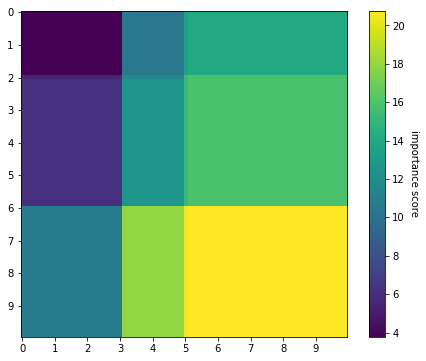

In [189]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(scores)
cbar_kw = {}
cbarlabel = "importance score"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
ax.set_xticks(np.arange(100, step=10))
ax.set_yticks(np.arange(100, step=10))
ax.set_xticklabels(np.round(np.arange(0, 10, step = 1), 2))
ax.set_yticklabels(np.round(np.arange(0, 10, step = 1), 2))
plt.show()

In [103]:
#generate data
x0 = np.random.uniform(0, 10, (10000, 1))
x1 = np.random.uniform(0, 10, (10000, 1))
X = np.hstack((x0, x1))
Y = 3 * (x0 > 4) + 8 * (x1 > 9) + 10 * (np.logical_and(x0 < 3, x1 > 7))
labels = ['x0', 'x1']

In [104]:
model = DecisionTreeRegressor()
model.fit(X, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [105]:
vals = traverse_all_paths(model, X, Y, [1, 0], continuous_y = True)
scores = make_line(vals, (0, 10), .1, 0, 2)
e_vals = (x_axis < 3) * .3
true_vals = 3 * (x_axis > 4) + 8 * (.1) + 10 * e_vals
rmse = np.mean(np.sqrt((scores - true_vals) ** 2))
strmse = "rmse between curves = " + str(round(rmse, 3))

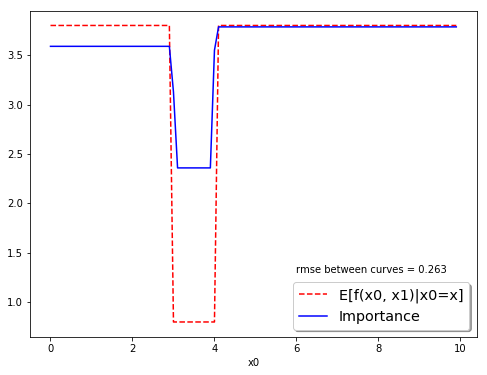

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, true_vals, 'k--', c='r', label='E[f(x0, x1)|x0=x]')
plt.plot(x_axis, scores, 'k', c='b', label='Importance')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.text(6, 1.3, strmse)
plt.xlabel('x0')
plt.show()

In [145]:
#generate data
x0 = np.random.uniform(0, 10, (10000, 1))
x1 = np.random.uniform(0, 10, (10000, 1))
X = np.hstack((x0, x1))
Y = 10 * (np.logical_or(x0 < 3, x1 > 7))
labels = ['x0', 'x1']

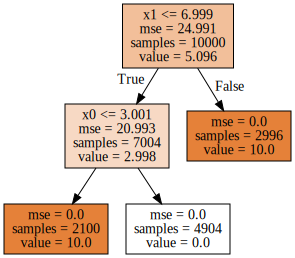

In [146]:
model = DecisionTreeRegressor()
model.fit(X, Y)
#visualizing the tree
graph = Source(tree.export_graphviz(model, out_file=None
   , feature_names=labels, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [147]:
vals = traverse_all_paths(model, X, Y, [1, 0], continuous_y = True)
scores = make_line(vals, (0, 10), .1, 0, 2)
e_vals = (x_axis >= 3) * .3 + (x_axis < 3)
true_vals = 10 * e_vals#3 * (x_axis > 4) + 8 * (.1) + 10 * e_vals
rmse = np.mean(np.sqrt((scores - true_vals) ** 2))
strmse = "rmse between curves = " + str(round(rmse, 3))

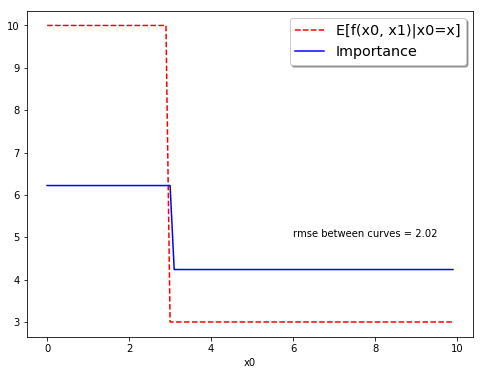

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, true_vals, 'k--', c='r', label='E[f(x0, x1)|x0=x]')
plt.plot(x_axis, scores, 'k', c='b', label='Importance')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.text(6, 5, strmse)
plt.xlabel('x0')
plt.show()

In [115]:
#generate data
x0 = np.random.uniform(0, 10, (10000, 1))
x1 = np.random.uniform(0, 10, (10000, 1))
X = np.hstack((x0, x1))
Y = 5 * np.logical_and(x0 < 5, x1 > 9) +  8 * (np.logical_or(x0 < 3, x1 > 7))
labels = ['x0', 'x1']

In [116]:
model = DecisionTreeRegressor()
model.fit(X, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [117]:
vals = traverse_all_paths(model, X, Y, [1, 0], continuous_y = True)
scores = make_line(vals, (0, 10), .1, 0, 2)
e_and = (x_axis < 5) * .1
e_or = (x_axis >= 3) * .3 + (x_axis < 3)
true_vals = 5 * e_and + 8 * e_or
rmse = np.mean(np.sqrt((scores - true_vals) ** 2))
strmse = "rmse between curves = " + str(round(rmse, 3))

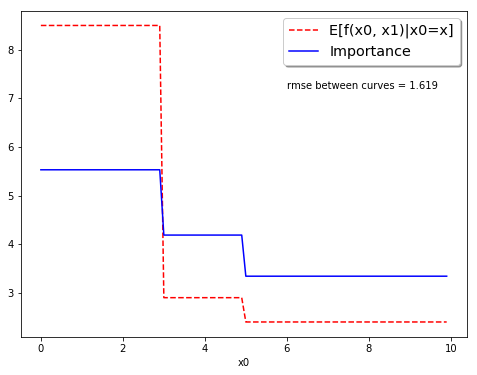

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, true_vals, 'k--', c='r', label='E[f(x0, x1)|x0=x]')
plt.plot(x_axis, scores, 'k', c='b', label='Importance')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.text(6, 7.2, strmse)
plt.xlabel('x0')
plt.show()

In [150]:
def make_figures(cols, labels, S, f, e, textpos, graph_label='E[f(x0, x1)|x0=x]'):
    X = np.random.uniform(0, 10, (10000, cols))
    Y = f(X)
    model = DecisionTreeRegressor()
    model.fit(X, Y)
    graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=labels, class_names=['0', '1'] 
       , filled = True))
    display(SVG(graph.pipe(format='svg')))
    vals = traverse_all_paths(model, X, Y, S, continuous_y = True)
    scores = make_line(vals, (0, 10), .1, np.nonzero(S)[0][0], cols)
    x_axis = np.arange(0, 10, .1)
    true_vals = e(x_axis)
    rmse = np.mean(np.sqrt((scores - true_vals) ** 2))
    strmse = "rmse between curves = " + str(round(rmse, 3))
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, true_vals, 'k--', c='r', label=graph_label)
    plt.plot(x_axis, scores, 'k', c='b', label='Importance')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.text(textpos[0], textpos[1], strmse)
    plt.show()

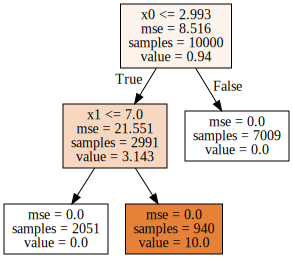

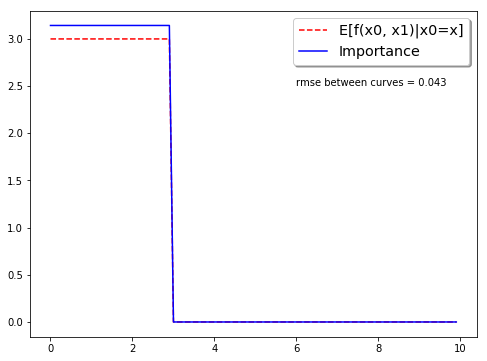

In [156]:
cols = 2
labels = ['x0', 'x1']
S = [1, 0]
f = lambda X: 10 * (np.logical_and(X[:, 0] < 3, X[:, 1] > 7))
e = lambda x: 10 * (x < 3) * .3
textpos = (6, 2.5)
make_figures(cols, labels, S, f, e, textpos)

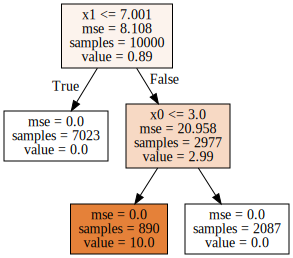

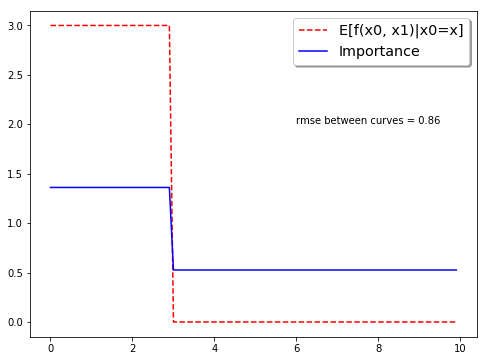

In [157]:
cols = 2
labels = ['x0', 'x1']
S = [1, 0]
f = lambda X: 10 * (np.logical_and(X[:, 0] < 3, X[:, 1] > 7))
e = lambda x: 10 * (x < 3) * .3
textpos = (6, 2)
make_figures(cols, labels, S, f, e, textpos)

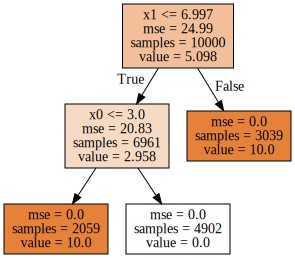

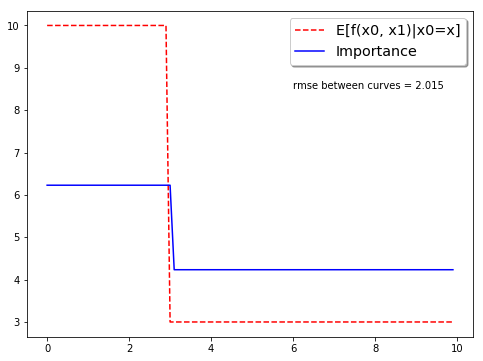

In [161]:
cols = 2
labels = ['x0', 'x1']
S = [1, 0]
f = lambda X: 10 * (np.logical_or(X[:, 0] < 3, X[:, 1] > 7))
e = lambda x: 10 * ((x < 3) + (x >= 3) * .3)
textpos = (6, 8.5)
make_figures(cols, labels, S, f, e, textpos)

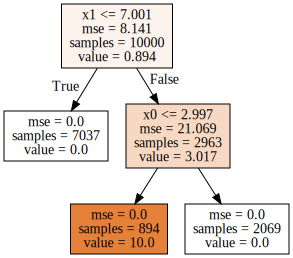

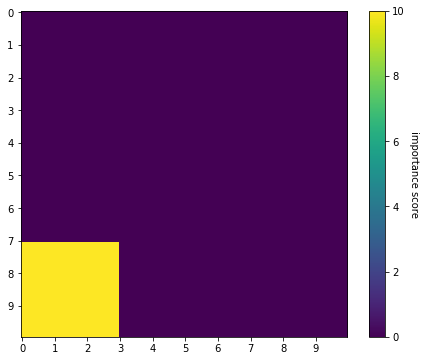

In [195]:
X = np.random.uniform(0, 10, (10000, 2))
labels = ['x0', 'x1']
f = lambda X: 10 * (np.logical_and(X[:, 0] < 3, X[:, 1] > 7))
Y = f(X)
model = DecisionTreeRegressor()
model.fit(X, Y)
graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=labels, class_names=['0', '1'] 
       , filled = True))
display(SVG(graph.pipe(format='svg')))
S = [1, 1]
vals = traverse_all_paths(model, X, Y, S, continuous_y = True)
scores = make_grid(vals, (0, 10), (0, 10), .1, cols)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(scores)
cbar_kw = {}
cbarlabel = "importance score"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
ax.set_xticks(np.arange(100, step=10))
ax.set_yticks(np.arange(100, step=10))
ax.set_xticklabels(np.round(np.arange(0, 10, step = 1), 2))
ax.set_yticklabels(np.round(np.arange(0, 10, step = 1), 2))
plt.show()

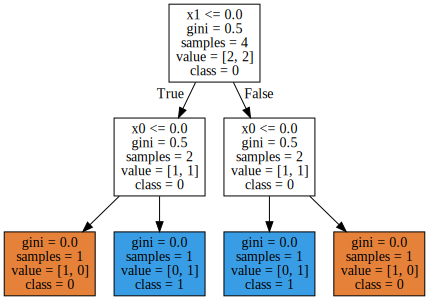

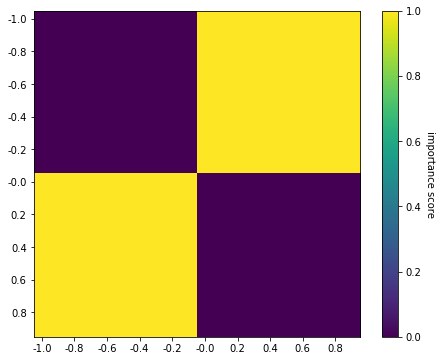

In [224]:
X = np.array([[-1, 1], [1, 1], [-1, -1], [1, -1]])
labels = ['x0', 'x1']
Y = np.transpose(X[:, 0] * X[:, 1] < 0)
model = DecisionTreeClassifier(max_depth=2)
model.fit(X, Y)
graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=labels, class_names=['0', '1'] 
       , filled = True))
display(SVG(graph.pipe(format='svg')))
S = [1, 1]
vals = traverse_all_paths(model, X, Y, S, continuous_y = False)
scores = make_grid(vals, (-1, 1), (-1, 1), .1, cols)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(scores)
cbar_kw = {}
cbarlabel = "importance score"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
ax.set_xticks(np.arange(20, step=2))
ax.set_yticks(np.arange(20, step=2))
ax.set_xticklabels(np.round(np.arange(-1, 1, step = .2), 2))
ax.set_yticklabels(np.round(np.arange(-1, 1, step = .2), 2))
plt.show()

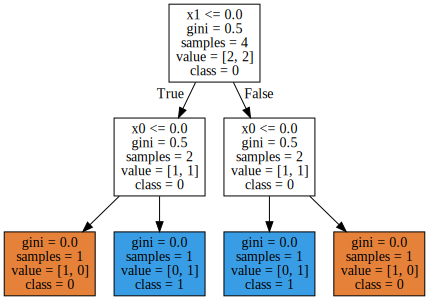

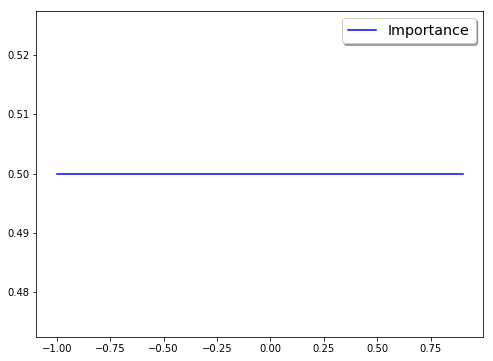

In [223]:
X = np.array([[-1, 1], [1, 1], [-1, -1], [1, -1]])
labels = ['x0', 'x1']
Y = np.transpose(X[:, 0] * X[:, 1] < 0)
model = DecisionTreeClassifier(max_depth=2)
model.fit(X, Y)
graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=labels, class_names=['0', '1'] 
       , filled = True))
display(SVG(graph.pipe(format='svg')))
S = [1, 0]
vals = traverse_all_paths(model, X, Y, S, continuous_y = False)
scores = make_line(vals, (-1, 1), .1, 0, 2)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
x_axis = np.arange(-1, 1, .1)
plt.plot(x_axis, scores, 'k', c='b', label='Importance')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()